## Imports and Environment Setup


In [22]:
#%%capture

# @title Install MuJoCo
!pip install mujoco
#@title Check if installation was successful

# from google.colab import files

import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# Torch setup
import torch
from torch import nn, zeros
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from collections import deque
import random
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.
Installing mediapy:
Using device: cuda


In [68]:
# @title Load simple connector MJCF as `xml`
xml = """
<mujoco>
  <default>
    <geom density="1" solimp="0.0 0.1 0.1 0.5 2"/>
    <!-- <geom solimp="0.0 0.1 0.1 0.5 2" /> -->
  </default>

  <visual>
    <map force="0.1"/>
    <headlight ambient="0.7 0.7 0.7"/>
    <rgba contactforce="0.7 1.0 1.0 .6"/>
  </visual>

  <visual>
  <global offwidth="1024" offheight="1024"/>
  <rgba haze="0.15 0.25 0.35 1"/>
</visual>


  <option>
    <flag gravity="disable"/>
  </option>


<asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0."/>
  </asset>

  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <geom name="floor" pos="0 0 -0.1" size="0 0 0.05" type="plane" material="grid"/>
    <light name="spotlight" mode="targetbodycom" target="m" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="f">
      <geom name="left" type="box" pos="-0.65 0 1" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <body name = "fb1" >
        <geom name="fb1" size=".075" pos=".5 .45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb2" >
        <geom name="fb2" size=".075" pos="-.5 .45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb3" >
        <geom name="fb3" size=".075" pos=".5 -.45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb4" >
        <geom name="fb4" size=".075" pos="-.5 -.45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <geom name="right" type="box" pos="0.65 0 1" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <geom name="bottom" type="box" size=".8 .45 .15" rgba=".4 .4 .4 .2"/>
      <geom name="side1" type="box" pos="0 0.6 .85" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <geom name="side2" type="box" pos="0 -0.6 .85" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <site name="FT"/>
    </body>


    <body name="m" pos="0 0 3">
      <joint type="slide" name="pos_z" axis="0 0 1"/>
      <joint pos="0 0 1" type="hinge" name="rot_y" axis="0 1 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_x" axis="1 0 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_z" axis="0 0 1"/>
    <geom name="male" type="box" size = ".45 .4 1.0" rgba=".4 .2 .1 .5" />
      <body name = "mb1" >
        <geom name="mb1" size=".085" pos="0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb2" >
        <geom name="mb2" size=".085" pos="-0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb3" >
        <geom name="mb3" size=".085" pos=".45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb4" >
        <geom name="mb4" size=".085" pos="-.45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <camera name="track" pos="0 -6 0" xyaxes="1 0 0 0 .2 1" mode="track"/>
    </body>
  </worldbody>

  <default>
    <general ctrlrange="-3 3" ctrllimited="true" biastype="affine"/>
  </default>

  <actuator>
    <general name="pos_z" joint="pos_z" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_x" joint="rot_x" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_y" joint="rot_y" gainprm="10" biasprm="0 0 -10"/>
    <general name="rot_z" joint="rot_z" gainprm="10" biasprm="0 0 -10"/>
  </actuator>

  <sensor>
    <force name="force" site="FT"/>
    <torque name="torque" site="FT"/>
  </sensor>

  <contact>
    <exclude body1="f" body2="fb1"/>
    <exclude body1="f" body2="fb2"/>
    <exclude body1="f" body2="fb3"/>
    <exclude body1="f" body2="fb4"/>
    <exclude body1="m" body2="mb1"/>
    <exclude body1="m" body2="mb2"/>
    <exclude body1="m" body2="mb3"/>
    <exclude body1="m" body2="mb4"/>
    <exclude body1="fb1" body2="mb1"/>
    <exclude body1="fb1" body2="mb2"/>
    <exclude body1="fb1" body2="mb3"/>
    <exclude body1="fb1" body2="mb4"/>
    <exclude body1="fb2" body2="mb1"/>
    <exclude body1="fb2" body2="mb2"/>
    <exclude body1="fb2" body2="mb3"/>
    <exclude body1="fb2" body2="mb4"/>
    <exclude body1="fb3" body2="mb1"/>
    <exclude body1="fb3" body2="mb2"/>
    <exclude body1="fb3" body2="mb3"/>
    <exclude body1="fb3" body2="mb4"/>
    <exclude body1="fb4" body2="mb1"/>
    <exclude body1="fb4" body2="mb2"/>
    <exclude body1="fb4" body2="mb3"/>
    <exclude body1="fb4" body2="mb4"/>
  </contact>



</mujoco>
"""

In [81]:
# Environment Setup as a custom gym environment
from typing import Optional
import numpy as np
import gymnasium as gym
from scipy.spatial.transform import Rotation

class PluggingEnv(gym.Env):
    def __init__(self, xml, reset_noise_scale, record_video=False):
        # make model and data
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)
        self.n_steps_per_call = 10
        dt = 1/600
        self.model.opt.timestep = dt
        self.observation_space = gym.spaces.Box(low=-40, high=40, shape=(8+6+3,)) # 4 pos, 4 vel, 6 dof force, 3 rotations of plug
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(4,)) # 4 joint actions
        self.max_steps = 100
        self.step_count = 0
        self.reset_noise_scale = reset_noise_scale
        self.record_video = record_video
        self.framerate = 1/(dt*self.n_steps_per_call)
        if(self.record_video):
            self.frames = []

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(self.model)
        self.step_count = 0
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos = np.array([0, 0, 0, 0])
        self.data.qvel = np.zeros_like(self.data.qpos)
        if(options is not None):
            self.rpy = options['rpy']
        else:
            self.rpy = self.reset_noise_scale*(np.random.rand(3)-0.5)
        rotation = Rotation.from_euler('xyz', self.rpy)
        self.model.body("f").quat = rotation.as_quat(scalar_first=True)          
        if(self.record_video):
            # make renderer, render and show the pixels
            self.renderer = mujoco.Renderer(self.model, width=1000, height=1000)
            self.options = mujoco.MjvOption()
            
            # turn on contact force visualizer
            mujoco.mjv_defaultOption(self.options)
            self.options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
        
        obs, _, _, _, info = self.step(self.data.qpos.copy())
        
        return obs, info

    def _get_obs(self):
        state = np.concatenate((
        self.data.qpos.copy(),
        self.data.qvel.copy()
        ))
        force = np.concatenate((
            self.data.sensor('force').data,
            self.data.sensor('torque').data,
        ))
        rpy = self.rpy
        return state, force, rpy

    def _get_reward(self, state, action, force):
        Q = np.diag([10, 0.1, 0.1, 0.1, 1, 0.1, 0.1, 0.1]) # Only care that the final z position is low and it has stopped at the bottom
        R = 0.1*np.diag([1, 1, 1, 1])
        S = np.diag([1, 1, 1, 1, 1, 1])
        return -(100*state[0]+ action@R@action.T + force@S@force.T)

    def step(self, action):
        self.data.ctrl = np.clip(action, -3, 3)
        mujoco.mj_step(self.model, self.data, nstep = self.n_steps_per_call)
        state, force, rpy = self._get_obs()
        reward = self._get_reward(state, action, force)
        observation = np.concatenate((state, force, rpy))
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        #if terminated:
            #print(reward)
        truncated = np.linalg.norm(state[0:3]) > 5
        info = dict()
        if(self.record_video):
            self.renderer.update_scene(self.data, "track", self.options)
            pixels = self.renderer.render()
            self.frames.append(pixels)
        return observation, reward, terminated, truncated, info

    def get_frames(self):
        return self.frames


gym.register(
    id="DRL/PluggingEnv",
    entry_point=PluggingEnv,
)



In [73]:
class ReplayBuffer:
    def __init__(self):
        self.buffer = deque(maxlen=1_000_000)
        self.batch_size = 32

    def store(self, state, action, reward, next_state, done):
        transitions = list(zip(state, action, reward, next_state, 1 - torch.Tensor(done)))
        self.buffer.extend(transitions)

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        return [torch.stack(e).to(device) for e in zip(*batch)]  # states, actions, rewards, next_states, not_dones

In [74]:
class DRL:
    def __init__(self):
        self.n_envs = 32
        self.n_steps = 128

        self.envs = gym.vector.SyncVectorEnv(
            [lambda: gym.make("DRL/PluggingEnv", reset_noise_scale=0.2, xml=xml) for _ in range(self.n_envs)])

        self.replay_buffer = ReplayBuffer()

    def rollout(self, agent, i):
        """Collect experience and store it in the replay buffer"""

        obs = torch.Tensor(self.envs.reset()[0])

        total_rewards = torch.zeros(self.n_envs)

        for _ in range(self.n_steps):
            with torch.no_grad():
                actions = agent.get_action(obs.to(device), noisy=True).cpu()
            next_obs, rewards, done, truncated, _ = self.envs.step(actions.numpy())
            next_obs, rewards = torch.Tensor(next_obs), torch.Tensor(rewards)
            # reward scaling by .01 keeps sum of rewards near 1, increases stability
            self.replay_buffer.store(obs, actions, rewards*.01, next_obs, done | truncated)
            obs = next_obs

            total_rewards += rewards

        writer.add_scalar("stats/Rewards", total_rewards.mean().item() / self.n_steps, i)

In [27]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 66001), started 2 days, 20:51:32 ago. (Use '!kill 66001' to kill it.)

# DDPG Setup

In [42]:
class DDPG:
    def __init__(self, n_obs, n_actions):
        self.exploration_rate = 1.
        torch.manual_seed(0)

        # todo: student code here
        self.q_net = nn.Sequential(
            nn.Linear(n_obs+n_actions, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        self.policy = nn.Sequential(
            nn.Linear(n_obs, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        ).to(device)

        self.q_target_net = nn.Sequential(
            nn.Linear(n_obs+n_actions, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).to(device)
        self.policy_target_net = nn.Sequential(
            nn.Linear(n_obs, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        ).to(device)
        self.n_obs = n_obs
        self.n_actions = n_actions
        self.q_optimizer = Adam(self.q_net.parameters(), 3e-4)
        self.policy_optimizer = Adam(self.policy.parameters(), 3e-4)
        # end student code


    def get_action(self, states, noisy=False):
        actions = self.policy(states)
        if noisy:
          actions += torch.normal(0, self.exploration_rate, size=actions.shape).to(device)
        return actions.clamp(-3, 3)

    def get_target_action(self, next_states):
        actions = self.policy_target_net(next_states)
        return actions.clamp(-3, 3)

    def get_q_loss(self, states, actions, rewards, next_states, not_dones, gamma=.99):

        #todo: student code here
        with torch.no_grad():
            # hint: get_target_action
            target_actions = self.get_target_action(next_states)
        target_q = rewards + gamma*not_dones*torch.t(self.q_target_net(torch.cat((next_states, target_actions), 1)))
        # print(torch.cat((states, actions), 1))
        Q = torch.t(self.q_net(torch.cat((states, actions), 1)))
        Q_loss = nn.MSELoss()(target_q, Q)
        # end student code
        return Q_loss


    def get_policy_loss(self, states):
        # todo: student code here
        # hint: get_action
        actions = self.get_action(states)

        return -self.q_net(torch.cat((states, actions),1)).mean()

        # end student code
        # return policy_loss


    def update(self, replay_buffer, i):

        for _ in range(64):
            loss = self.get_q_loss(*replay_buffer.sample())
            self.q_optimizer.zero_grad()
            loss.backward()
            self.q_optimizer.step()
        writer.add_scalar("loss/q loss", loss.item(), i)

        for _ in range(4):
            states, _, _, _, _ = replay_buffer.sample()
            loss = self.get_policy_loss(states)
            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()
        writer.add_scalar("loss/ - policy loss", -loss.item(), i)

        tau = 0.1  # Continual soft target update
        for target_param, param in zip(self.q_target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(self.policy_target_net.parameters(), self.policy.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        self.exploration_rate  = max(self.exploration_rate  * 0.985, 0.1)
        writer.add_scalar("stats/exploration rate", self.exploration_rate , i)

-0.231453671066379
-0.3864500193176299
-0.8973297796580595
-0.6319192192354488
-0.6481929732352792
-0.6493818711166107
-0.5526597648118464
-0.5824213723466253
-0.5384041863053294
-0.5492869640964831
-0.49381032508157247
-0.735588665278291
-0.5281182205191831
-0.5029798816596132
-0.4363952314761746
-0.4874959365280627
-0.36611906870041483
-0.33808213715030627
-0.40395065291944926
-0.403684707731365
-0.6514268858092027
-0.4479425976156929
-0.6064797496313625
-0.40544298943179874
-0.4682955147377324
-0.6130933392825342
-0.5125721571987855
-0.28196803792684094
-0.48306213809050136
-0.8284152082482126
-0.6269506846728434
-0.8116898493665983
-0.6082282664598544
-0.8816238615668176
-0.45526466657182335
-0.21225497638431542
-0.666699574592068
-0.36831938845978857
-0.17333617749628352
-0.43781215744520074
-0.7134024532834585
-0.5178747931661603
-0.7655465507518353
-0.3019608296383321
-0.4168797714647765
-0.4970196365082354
-0.5416230459473306
-0.6680769158585634
-0.1809389608489938
-0.323737318

-0.3806827660593263
-0.3909164575247887
-0.6216539970596353
-0.39820330679668237
-0.5122602013319886
-0.81587997448756
-0.3672776940937603
-0.2953609476167432
-0.4303260912701824
-0.4821047227511699
-0.030454273660994843
-0.6267706084873749
-0.45235215625229935
-0.5850983226124208
-0.6244302959222968
-0.8646837437017365
-0.42624269620885674
-0.5606419372387506
-0.6444968371918545
-0.5936265816844339
-0.35245338184190717
-0.4216817817871353
-0.5433193273894673
-1.066872905260896
-0.747730757733118
-0.4439401645140501
-0.4129859129737364
-0.6698315343280324
-0.6219200368781035
-0.4953857106569371
-0.761953719813456
-0.37219629342431654
-0.3242106817591919
-0.6257169201051294
-0.5406114987855001
-0.5325425891995729
-0.5156416108053405
-0.7042675538217936
-0.4945385780713278
-0.5209112830988487
-0.16838941978968294
-0.6223739390120268
-0.18249820424554836
-0.665052089537673
-0.42168467508046126
-0.43687896663270653
-0.8890105238484618
-0.34271336748514614
-0.26339054028035996
-0.8727030843

-0.680341063028284
-0.5321463549412814
-0.9130884110760485
-0.17972452626006274
-0.5211130069890433
-0.44992887024019157
-0.5901046056338664
-0.34450951525413326
-0.6806593623105845
-0.4565347633027335
-0.40784829556162505
-0.6402012708083169
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1798        |
|    iterations           | 37          |
|    time_elapsed         | 42          |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.013642142 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.65       |
|    explained_variance   | 0.598       |
|    learning_rate        | 0.003       |
|    loss                 | 0.336       |
|    n_updates            | 360         |
|

-0.7592591996152518
-0.3089024941105312
-0.43789456250755
-0.5556119744843524
-0.3184159602380918
-0.3013573827006125
-0.3465121095754801
-0.4655235053542262
-0.21462462277932895
-0.37210358640191776
-0.2919182560656099
-0.5754087572851382
-0.3159451305088102
-0.515419546479786
-0.5588631571901382
-0.26115347872252753
-0.4008772819535553
-0.3420830229854592
-0.5810603383344143
-0.4599166072454778
-0.3801514035075913
-0.6570198759759381
-0.9924165642897612
-0.3971966877100666
-0.14025915193621652
-0.8717760370545836
-0.6770016601830999
-0.6553581947053508
-0.3983764769164545
-0.2578823510021882
-0.3790151147948519
-1.0162779409403593
-0.5085497702250269
-0.5785507140773894
-0.23149573925026165
-0.6519334264371048
-0.4201135423288833
-0.5172904463360968
-0.5995635120008836
-0.4048955714470753
-0.40633134795629655
-0.4323471874888572
-0.18203836883405097
-0.7146684260220122
-0.8687781104821863
-0.5601744768959372
-0.22691923968506636
-0.38622626332838494
-0.667944979887896
-0.355219601093

-0.956905960761851
-0.7785417174142691
-0.36698925320006304
-0.6752637371482175
-0.675168502421896
-0.5813340779824914
-0.5407654535741909
-0.7382933644158638
-0.49219487278269003
-0.17702965401008094
-0.4817954739268746
-0.8176434912930609
-0.4966393761940944
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1797        |
|    iterations           | 44          |
|    time_elapsed         | 50          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.015518151 |
|    clip_fraction        | 0.196       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.47       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.003       |
|    loss                 | 0.44        |
|    n_updates           

-0.48784719328878773
-0.5502371448092553
-0.26095493605518205
-0.2107137063601472
-0.4543006165603711
-0.5631737314806876
-0.6518692096288583
-0.4480264257766202
-0.3770570726516806
-0.5722602929228932
-0.3644826028526457
-0.7249821563174905
-0.3004320163519674
-0.24571040077806913
-0.09401011594301295
-0.20140042594710758
-0.39404822943426093
-0.5822272098081686
-0.350739886594393
-0.4295353314321812
-0.7199528214091342
-0.13638468423495084
-0.5408615754982422
-0.43089187212004126
-0.37828777107693734
-0.5166886863000518
-0.5975129326103029
-0.47703996552728223
-0.3260941615117648
-0.1761948105894376
-0.48096499177748075
-0.3108950098416496
-0.432032286196447
-0.44297451403212934
-0.368648448866486
-0.34658732400620806
-0.5370030026273604
-0.3105702422164492
-0.5383017608912172
-0.28590539302476115
-0.21050322998817253
-0.5548458172668652
-0.5707278604589183
-0.2150440479459156
-0.6158717411091601
-0.38541230124982634
-0.2776641212673976
-0.4423978554386891
-0.34655961658064594
-0.519

-0.3494507584449928
-0.6478787226436606
-0.7404376916637035
-0.7252049201591491
-0.5006405275492212
-0.5386088691642216
-0.547362596640179
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.5       |
| time/                   |             |
|    fps                  | 1804        |
|    iterations           | 51          |
|    time_elapsed         | 57          |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.013583237 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.32       |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.003       |
|    loss                 | 0.381       |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0133     |
|    std                  | 0.817       |
|    value_loss      

-0.7833250265094763
-0.625756434210368
-0.5405799504719865
-0.6797377182620272
-0.9404539373724189
-0.7963844683121234
-0.5688829125281841
-0.5944045647852884
-0.9970134219149397
-0.4433893338653154
-0.8775779193062669
-0.4002015900366463
-0.520240807845157
-0.4539180018345374
-0.27613811508372943
-0.6480804782932478
-0.4904688398574722
-0.8293643536264805
-0.5627380735779342
-0.3477411061298958
-0.2858241420994127
-0.3506877230305782
-0.20581548712899247
-0.3870439023596911
-0.6900722353143794
-0.4596656318001571
-0.6585842956934821
-0.44335464314130085
-0.596706333900706
-0.47174343289181153
-0.5309405323419212
-0.6543618348422109
-0.48080012226377394
-0.479115467022291
-0.5077524712053183
-0.7205510352781478
-0.2753767780154458
-0.18749359585860445
-0.8472725093415301
-0.6358901079408633
-0.19260635182567795
-0.39803464219701795
-0.17188291334222316
-0.48294699153994575
-0.14321936918999903
-0.4602676457675461
-0.5592813473381193
-0.7104666976155151
-0.7284855016346491
-0.4510141377

-0.3421591931459523
-0.2613812867051514
-0.33676647415386707
-0.6924574308411195
-0.276524310174176
-0.5852324276023688
-0.706087530844055
-0.32277223498523927
-0.47896961264166094
-0.5443671998426662
-0.31408342855353577
-0.3135296706151729
-0.4062712324651763
-0.8096281465974514
-0.5041944218663382
-0.9131668999084039
-0.4316962553406392
-0.4072322987524674
-0.8773968461389211
-0.6504253437283387
-0.0964863007376314
-0.35119486781623654
-0.46083980864611973
-0.45044868157365253
-0.3048768302678961
-0.5974578000392554
-0.36220896369514577
-0.29621957168115465
-0.5031284797246562
-0.12268226626890728
-0.5457635012370762
-0.5270793632445427
-0.6126271753981432
-0.4937660898104847
-0.6192191262513964
-0.8573871449222958
-0.40470627632004164
-0.43028015463537
-0.30946182106466613
-0.5781002261902334
-0.27177951290131525
-0.219298113393351
-0.5049305907337606
-0.6215117539619437
-0.5169791090881322
-0.5599182831667696
-0.38978824071918916
-0.44135201562340026
-0.3984043149688886
-0.5160254

-0.0903779603038064
-0.4365712777682442
-0.6455989125537693
-0.3080577870902909
-0.3430618885983034
-0.710027957192152
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.5       |
| time/                   |             |
|    fps                  | 1831        |
|    iterations           | 62          |
|    time_elapsed         | 69          |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.014726501 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.73       |
|    explained_variance   | 0.695       |
|    learning_rate        | 0.003       |
|    loss                 | 0.363       |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.743       |
|    value_loss           | 0.881       |

-0.5341458353313912
-0.5651616349199857
-0.5559774672402754
-0.268569427592972
-0.3307408553668511
-0.3034676031553002
-0.49322343736250646
-0.4254757208993098
-0.5731464393922241
-0.27677485079569375
-0.3830080423384587
-0.36658941006303974
-0.31072554409613695
-0.4999447908994356
-0.3819714667106451
-0.4095432612762806
-0.7821829120126466
-0.6911303598615309
-0.23394720040563316
-0.4834848957354798
-0.8053539968983523
-0.7403478678325098
-0.4168969620874374
-0.4385358532668169
-0.686869290202174
-0.34427985357820295
-0.46541791607807803
-0.45194819675222037
-0.20770549855825687
-0.21770105755833122
-0.5903203726499953
-0.33555489123044585
-0.3994947625795716
-0.44472137627430935
-0.6061199023211148
-0.4151872681022087
-0.2380556834066059
-0.7218634952085472
-0.4568192925996086
-0.6639094915510775
-0.2934020891000324
-0.5516161869132755
-0.6529510724140921
-0.12066395784087554
-1.087604293185527
-0.595351361165477
-0.19449389239525894
-0.29995134155475905
-0.22270091402301817
-0.33172

-0.2930330640505307
-0.25093668429912475
-0.5341696127223853
-0.3112165958047232
-0.5242215645962012
-0.6817022993849751
-0.45083479256092773
-0.21554048405613585
-0.2941378483549061
-0.4866458151461528
-0.487792923287203
-0.5492641857760759
-0.47832219683869537
-0.5750176557009306
-0.7379273621491534
-0.3658057677672548
-0.10507110596503555
-0.17439050312215326
-0.6305101486932173
-0.48054618916118813
-0.4049168144898683
-0.41885627582336976
-0.27631366505485333
-0.5225428907491021
-0.4313833300894118
-0.4319847405563408
-0.4451597179644621
-0.4853630038340189
-0.4607828073165572
-0.6265505377290005
-0.6051865959116746
-0.37678993729027943
-0.46735303579444465
-0.6284567792367899
-0.5535028004822569
-0.5012770555609091
-0.4049287942617588
-0.8414521923429961
-0.6479033828770254
-0.6169277776170639
-0.42017393607812986
-0.41369595264134257
-0.6309619198481617
-0.4543290191114495
-0.5435563648842255
-0.22814098467798438
-0.7798307436092511
-0.1812919585727475
-0.32908267426036864
-0.777

-0.4497663024342759
-0.46067705516380897
-0.7542978755794534
-0.547148063543163
-0.4856747423807222
-0.7472162550632485
-0.578872247031499
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 29         |
|    ep_rew_mean          | -14.4      |
| time/                   |            |
|    fps                  | 1826       |
|    iterations           | 73         |
|    time_elapsed         | 81         |
|    total_timesteps      | 149504     |
| train/                  |            |
|    approx_kl            | 0.02169269 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -6.14      |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.003      |
|    loss                 | 0.373      |
|    n_updates            | 720        |
|    policy_gradient_loss | -0.0156    |
|    std                  | 0.674      |
|    value_loss           | 0.894      |


-0.7791980244740403
-0.5932073261871543
-0.5304992202529515
-0.7049025284633416
-0.6345576884425175
-0.6236153429943102
-0.5006805298958019
-0.3691931443456269
-0.4346212277826503
-0.6224848367310818
-0.8475714196702765
-0.6085784293093385
-0.4247070830831013
-0.43252020391169343
-0.36641888791332083
-0.43550764219239235
-0.21137948237192056
-0.6276729291631185
-0.4852256912489786
-0.35859457240663517
-0.5542374751929364
-0.5765965871996609
-0.14205038850529256
-0.6190564456016783
-0.6964071866114594
-0.5261902364623964
-0.8074658162716213
-0.2954935288875752
-0.4163378379315063
-0.6024810624391144
-0.34203756237224
-0.4927222215792834
-0.46051853140928767
-0.5562906943513711
-0.7390592052832231
-0.3619597948782843
-0.27452094690370943
-0.5322341201142392
-0.4435788594780122
-0.6313933226213021
-0.2254366241688965
-0.34685373336419917
-0.5704395584395039
-0.4394788962327652
-0.46281657027443135
-0.5070447760664094
-0.31072128304296526
-0.7482993595389976
-0.7619134071999845
-----------

-0.912396094685982
-0.28147679319566987
-0.4416368645956617
-0.7049943498480433
-0.5204806575404158
-0.5688334456485491
-0.5338775764194104
-0.4410082294536723
-0.6109150857355486
-0.6027403340415977
-0.7261488417093253
-0.7166614128471589
-0.40185418299021247
-0.5001211593250241
-0.20350203708676895
-0.5070547297259554
-0.39096963614455504
-0.42666227205225093
-0.3679160631270917
-0.32309249561380143
-0.5714845510666222
-0.6110122776495781
-0.4868115514445067
-0.37794585265683267
-0.4923644833399869
-0.5602508486645186
-0.3632395865798779
-0.7682756311593302
-0.40619759567201374
-0.26651727541905573
-0.6623464789770759
-0.24967945997296542
-0.5515378023994408
-0.6616703452074135
-0.3588692471490915
-0.2950277074004267
-0.7723005126107825
-0.1040843092073322
-0.5503467070550873
-0.7289526019955407
-0.36818110738641313
-0.48866920792413543
-0.3997564613280953
-0.8796280201744192
-0.39964066225436407
-0.6582709504768993
-0.43980889779891635
-0.741947517630059
-0.5359542622810495
-0.47931

-0.2128277410716308
-0.3844791173701643
-0.39165620034113835
-0.21087527998380717
-0.4802753083655798
-0.5402109965153992
-0.3584733230400292
-0.4144930657903331
-0.6821466090629199
-0.2115771103893945
-0.2955480612172935
-0.6682946301859773
-0.6631064876564813
-0.36492451287783817
-0.43248362490138187
-0.5104277879325076
-0.38984873657218805
-0.1919709866556078
-0.34803020120977696
-0.38315564648259454
-0.3946556231990351
-0.3028750519843263
-0.5642910535488334
-0.6956530785095922
-0.47853242844327
-0.1953028494511656
-0.12930143365963093
-0.39994316336850927
-0.3592471324512492
-0.6604109476379701
-0.8375897775298762
-0.2905399790986896
-0.43191625555634017
-0.7124524169985619
-0.4418668961625675
-0.6126096429735126
-0.3238579738483819
-0.7897703993443851
-0.9021459622792256
-0.6973429070874895
-0.45660369134929774
-0.4300709678800554
-0.5867090034466291
-0.44376463816217715
-0.6574885890928174
-0.4706299045959556
-0.6262374139912215
-0.7038045394635946
-0.6184044606265997
-0.8060698

-0.6673511974665252
-0.25871024249371743
-0.3320911241473458
-0.8384466718099743
-0.6864238668148724
-0.7212905991483708
-0.8005449581644193
-0.20922713567230386
-0.6153945815463593
-0.3770383247662638
-0.28379380241621055
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -14.4       |
| time/                   |             |
|    fps                  | 1822        |
|    iterations           | 88          |
|    time_elapsed         | 98          |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.019665388 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.4        |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.003       |
|    loss                 | 0.694       |
|    n_updates            | 870         |
|    policy_gradient_

-0.2536727997967522
-0.46667625091262116
-0.5800069399105912
-0.6916013861500117
-0.40468673448562487
-0.04913283733322324
-0.4042522231139154
-0.5001816501025435
-0.31447545635138907
-0.4465032963034878
-0.5142048540295451
-0.5532144418890353
-0.7789290068381782
-0.48217391147430416
-0.4160204371546305
-0.5719332703710841
-0.7455021558745829
-0.35817382087899713
-0.38968598419422806
-0.3944352505375315
-0.6422025126200708
-0.6207185208344783
-0.3295073595759879
-0.5718874113094388
-0.6039493290711194
-0.668377026972854
-0.37240407622122834
-0.4135028805011169
-0.3631801319598776
-0.6115957262844371
-0.5399230868562022
-0.5133730216784715
-0.3246240800724524
-0.6101766984671383
-0.2483971623468029
-0.44640740694400843
-0.7703327136109148
-0.24611131572554037
-0.3341609212551983
-0.47731084293729487
-0.38308741746823094
-0.34579778758617974
-0.21283361507815476
-0.5487952264481171
-0.8035324240794445
-0.13735500923200838
-0.19572680930449385
-0.5343717182911015
-0.43250110935711206
----

-0.5049631317486505
-0.3681086938391229
-0.41157029896694064
-0.8520953195874781
-0.3601381360344189
-0.47131484348217606
-0.5416808536856047
-0.5430531287578609
-0.6625870492347024
-0.26224628522095134
-0.7442158552230782
-0.5374696523196689
-0.48275621020123505
-0.531268922067049
-0.21429637540954372
-0.28630795623782634
-0.6919572543608675
-0.34989817872056833
-0.6211316276419984
-0.8251602049653413
-0.37805804286179967
-0.3164959834981823
-0.7413159546279873
-0.3470083667775599
-0.5127749915816493
-0.19570544393655032
-0.7871787892511821
-0.32627585191238534
-0.2701962453304498
-0.2858666339800051
-0.5590319045242257
-0.60052684425482
-0.30175918643543836
-0.4434398454993369
-0.45354404099102835
-0.5804477399651313
-0.3097946718371405
-0.47021010911816435
-0.3799698992515762
-0.5670238774419323
-0.5210515652336786
-0.3984361077985487
-0.5622307344196422
-0.5487911531369268
-0.5917712204535589
-0.5132998659712619
-0.4727158152012288
-0.32846247029774334
-0.32456860922076525
-0.55389

-0.8369495227661847
-0.3098215194734885
-0.6045716874941676
-0.7562061653642683
-0.42772932927953183
-0.1899684081602105
-0.6608648847094665
-0.350025557304889
-0.3311107876651887
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | -15.3       |
| time/                   |             |
|    fps                  | 1831        |
|    iterations           | 99          |
|    time_elapsed         | 110         |
|    total_timesteps      | 202752      |
| train/                  |             |
|    approx_kl            | 0.021693446 |
|    clip_fraction        | 0.268       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.84       |
|    explained_variance   | 0.67        |
|    learning_rate        | 0.003       |
|    loss                 | 0.395       |
|    n_updates            | 980         |
|    policy_gradient_loss | -0.0136     |
|    std              

-0.4415518131528909
-0.6069120996715193
-0.8116132715017057
-0.5909710127204463
-0.08703815670895591
-0.5552725619874443
-0.5486765973172092
-0.7914115443865316
-0.4684611637638479
-0.2580840050601569
-0.35659730615821644
-0.11261247150542814
-0.45538275249264937
-0.4788686324845276
-0.6036499645660861
-0.4562001938045055
-0.4942329791717563
-0.5623975250273163
-0.3570601735093514
-0.24962814333369793
-0.34642061461959595
-0.4504487104579498
-0.342089840521991
-0.5076405000617937
-0.18278000365865968
-0.5067758359108445
-0.6357631342121173
-0.3938551225613059
-0.3713728009827183
-0.7655201232759994
-0.3916479850636468
-0.5478139714818647
-0.4305838301152733
-0.3398778398181482
-0.5868728833939528
-0.4134848146017456
-0.4165413376827357
-0.5070014184818721
-0.4521510985266244
-0.6983251923393328
-0.41208036416789495
-0.2722514005568649
-0.6251215832749044
-0.4297072482983687
-0.27280664633746293
-0.7090717022150194
-0.5704913911242393
-0.32435520415937313
-0.5154658922925217
-0.10665010

In [85]:
# DDPG training loop

# tensorboard label can be changed with e.g. f'runs/unique_hyperparam_test'
writer = SummaryWriter(log_dir=f'runs/Plugging_4DOF_UP')

drl = DRL()
#ddpg = DDPG(n_obs=8+6+3, n_actions=4) # TODO: Pull n_obs, n_actinos from environment
#ddpg.exploration_rate = 1

# takes ~5-10 minutes on colab gpus
for i in range(512):

    drl.rollout(ddpg, i)
    ddpg.update(drl.replay_buffer, i)

print("Done Training!")

.3920.



































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































In [97]:
# @title Visualization code. Used later.
import os
# Graphics and plotting.
import mediapy as media

# Force MuJoCo to use EGL for rendering (important for Colab)
# os.environ["MUJOCO_GL"] = "egl"

def visualize(agent, start_pos, n_steps):
    """Visualize agent with a custom camera angle."""

    # Create environment in rgb_array mode
    env = gym.make("DRL/PluggingEnv", reset_noise_scale=0.01, xml=xml, record_video=True)
    #options = dict()
    #options['rpy'] = start_pos
    obs, _ = env.reset()
    obs_traj = np.zeros((n_steps, 17))
    act_traj = np.zeros((n_steps, 4))
    for t in range(n_steps):
        with torch.no_grad():
            actions = agent.get_action(torch.Tensor(obs).to(device))
            actions = actions.cpu().numpy()
            actions = np.zeros_like(actions)
            actions[0] = -1
        obs, _, done, _, _= env.step(actions)
        obs_traj[t, :] = obs
        act_traj[t, :] = actions

    media.show_video(env.unwrapped.get_frames(), fps=env.unwrapped.framerate, width = 500, height = 500)

    env.close()
    print(obs_traj)
    return obs_traj, act_traj




In [ ]:
misaligned_sensor_data, plot_actions = visualize(ddpg, np.array([0, 0, 0.1]), 500)

In [62]:
print(plot_actions) 

[[-0.04  -0.031  0.009 -0.208  0.106  0.037]
 [ 0.019 -0.047 -0.018 -0.08   0.018  0.024]
 [ 0.025 -0.023 -0.006 -0.061  0.002  0.023]
 ...
 [ 0.01   0.015 -0.018 -0.015 -0.006  0.04 ]
 [ 0.01   0.015 -0.018 -0.015 -0.006  0.04 ]
 [ 0.01   0.015 -0.018 -0.015 -0.006  0.039]]


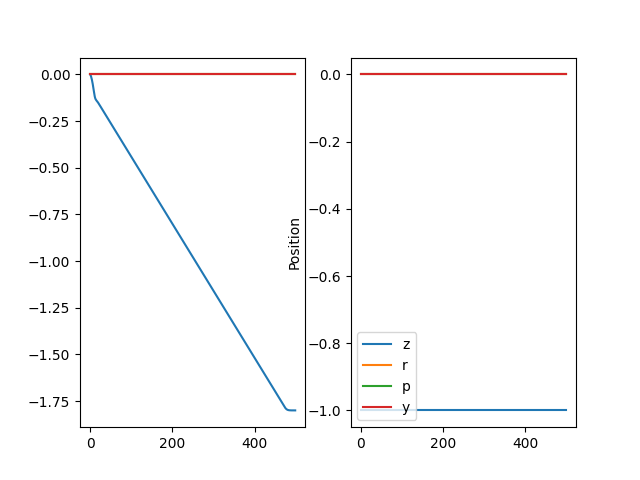

In [71]:
# @title Force torque data from misaligned plugging
# plot mj vs linear model
%matplotlib widget
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2)


labels = ['z', 'r', 'p', 'y']
ls = 'dotted'
for i in range(4):
    color = plt.get_cmap('tab10')(i)
    ax[0].plot(misaligned_sensor_data[:,i], color = color, label = labels[i])
plt.ylabel('Position')

for i in range(4):
    color = plt.get_cmap('tab10')(i)
    ax[1].plot(plot_actions[:,i], color = color, label = labels[i])
plt.ylabel('Position')
plt.legend(loc = 'lower left')


In [24]:
import pickle

with open("double_integrator_success.pkl", 'wb') as datafile:
    pickle.dump(ddpg, datafile)

In [26]:
import pickle

with open("ddpg.pkl", "rb") as f:
    ddpg = pickle.load(f)

EOFError: Ran out of input

Now let's test this policy in sim where we will add a constant offset to the control signal, and white noise to both the controller as well as the sensor.